In [30]:
from spreg import OLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from scipy import stats
from pysal.lib import weights
from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy import sparse
import warnings
from pysal.explore import esda


In [13]:
data = gpd.read_file("fcc_gwr.geojson")

In [14]:
display(data.head())

,area_id,category,bb_adoption_prop,fiber_prop,black_prop,gen_disp,pop_density,Redlined,distance_km,geometry
0,1205,Best,0.827600,0.544787,0.005213,0,1729.626373,0,7.552598,"MULTIPOLYGON (((677730.194 2139283.397, 678096..."
1,1199,Best,0.778415,0.789917,0.004173,0,2872.752429,0,5.590980,"MULTIPOLYGON (((678096.707 2139086.229, 678127..."
2,1368,Best,0.661332,0.059700,0.024011,0,9095.757014,0,2.206585,"MULTIPOLYGON (((687502.491 2134476.431, 687486..."
3,1402,Best,0.903770,0.038259,0.009325,0,4265.349552,0,0.301435,"MULTIPOLYGON (((689500.158 2130224.530, 689560..."
4,1595,Best,0.911871,0.000000,0.275479,0,1823.367065,0,0.668886,"MULTIPOLYGON (((686666.786 2110790.670, 686885..."


#### Weighted OLS and Assessing Spatial Patterns in the Residuals
- baseline global model to compare with local results of the GWR
- provides initial insights into overall relationships between explanatory and dependent variables
- check for spatial nonstationarity by looking at residual patterns


In [15]:
# prepare dependent and independent variables
y = np.array(data['fiber_prop'])
X = data[['Redlined', 'bb_adoption_prop', 'black_prop', 'gen_disp', 'pop_density']]

# scale pop_density (continuous variable, not a proportion) for numerical stability 
scaler = StandardScaler()
# display(X.head())
X['pop_density'] = scaler.fit_transform(X[['pop_density']])
# display(X.head())

X = np.array(X.assign(constant=1) )

X = X.astype(float)
y = y.astype(float)
y = y.reshape(-1, 1)


# get coordinates of centroid of each polygon
coords = np.column_stack((data.geometry.centroid.x,data.geometry.centroid.y))

# calculate spatial weights (using same kernel weight from autocorrelation)
w_adapt = weights.distance.Kernel.from_dataframe(
    data, fixed=False, k=10, function="gaussian", diagonal = False
)

#w_adapt.transform = "R"

# w_adapt.diagonal = 0

# w_adapt = w_adapt.full()[0] #convert to dense matrix
# w_adapt = csr_matrix(w_adapt)

/var/folders/q_/hxs6bprd6qz5xsd01jm_081h0000gn/T/ipykernel_3285/532957975.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['pop_density'] = scaler.fit_transform(X[['pop_density']])


In [16]:
print(data.crs)

EPSG:5070


In [17]:
type(w_adapt)

libpysal.weights.distance.Kernel

In [18]:
# Run weighted OLS
wls_model = sm.WLS(y, X, w=w_adapt)
wls_results = wls_model.fit()

print(wls_results.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.328
Model:                            WLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     33.46
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           8.45e-28
Time:                        03:12:27   Log-Likelihood:                 33.969
No. Observations:                 349   AIC:                            -55.94
Df Residuals:                     343   BIC:                            -32.81
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1348      0.027     -4.952      0.0

/Users/kendall/Library/Python/3.9/lib/python/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['w']
  warnings.warn(msg, ValueWarning)


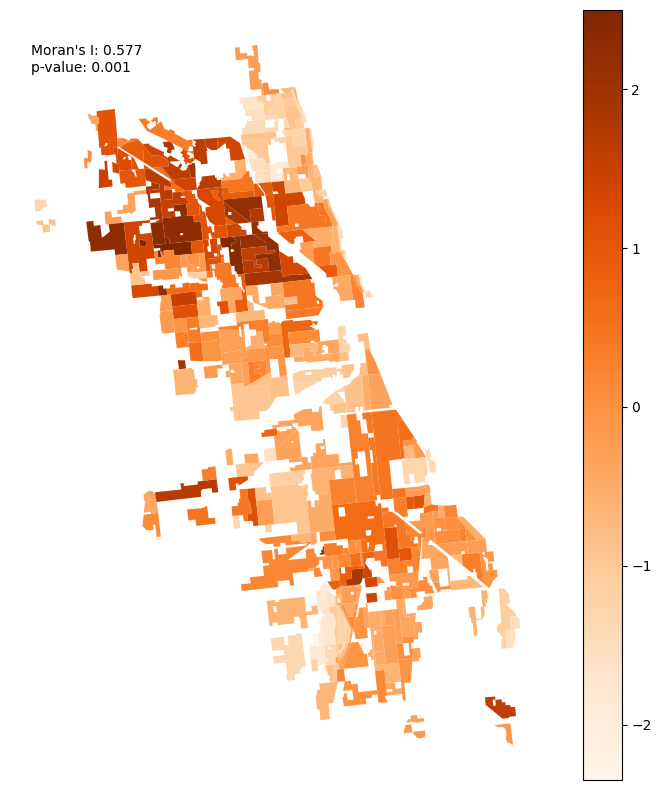

In [19]:
# plot residuals
map_1_gdf = data.copy()
map_1_gdf["WLS_residuals"] = wls_results.resid/ np.sqrt(wls_results.scale) #calculate and plot deviance residuals (more comparable across different GLMS including ols and logit)


map_1_gdf.plot(column="WLS_residuals", legend=True, figsize=(10, 10), cmap='Oranges')
#plt.title('Residuals by Location')
plt.axis("off")
resid_moran = esda.Moran(map_1_gdf["WLS_residuals"], w_adapt)
plt.text(0.04, 0.92, f"Moran's I: {resid_moran.I:.3f}\np-value: {resid_moran.p_sim:.3f}", transform=plt.gca().transAxes)
plt.show()


#### GWR: Fixed Optimal Bandwidth

In [10]:
try:
    # Fit GWR model
    gwr_model_fixed = GWR(coords, y, X, bw=2218.5, kernel='gaussian', fixed=True).fit()
    print(gwr_model_fixed.summary())
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Error type:", type(e).__name__)
    import traceback
    print(traceback.format_exc())

/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi

Model type                                                         Gaussian
Number of observations:                                                 349
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             16.819
Log-likelihood:                                                      33.969
AIC:                                                                -55.938
AICc:                                                               -53.610
BIC:                                                              -1991.470
R2:                                                                   0.328
Adj. R2:                                                              0.318

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

Text(0.5, 1.0, 'Significant Parameter Estimates')

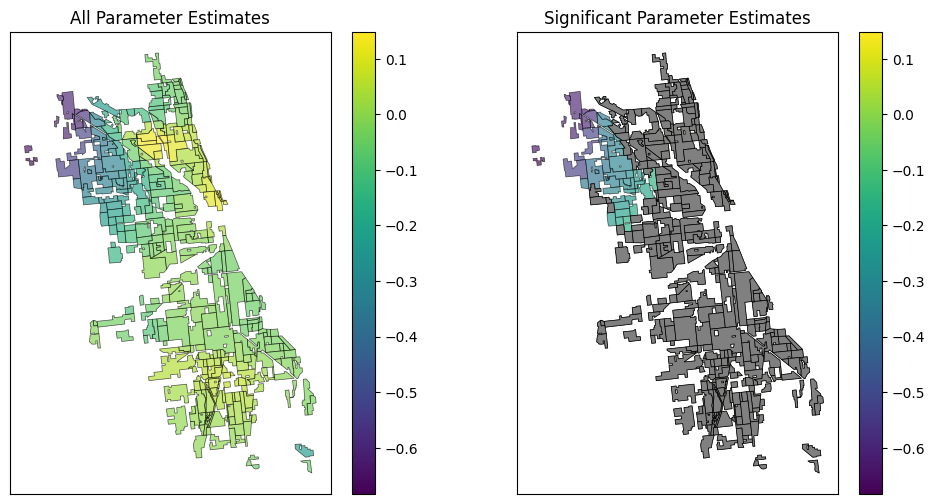

In [11]:
# Hypothesis Tests for Significance of parameter estimates (see Oshan et al., 2019)
map_1_gdf['Redlined_result_fixed'] = gwr_model_fixed.params[:,1]

# Filter tc gets t values with a correction for multiple dependent hypothesis tests -> distinguishes significant results
filter_tc_fixed = gwr_model_fixed.filter_tvals() 
map_1_gdf['Redlined_result_tc_fixed'] = filter_tc_fixed[:,1]

fig, ax = plt.subplots(1, 2, figsize = (12,6))

map_1_gdf.plot('Redlined_result_fixed',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[0],
            legend=True)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("All Parameter Estimates")

map_1_gdf.plot('Redlined_result_fixed',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[1],
            legend=True)

map_1_gdf[filter_tc_fixed[:,1] == 0].plot(color = 'grey',
                                    ax = ax[1],
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Significant Parameter Estimates")


#### GWR: Adaptive Bandwidth

In [20]:
warnings.filterwarnings('ignore')

bw_selector = Sel_BW(coords, y, X, kernel='gaussian', fixed=False) # try with adaptive bandwidth (fixed = false) and check results

bw = bw_selector.search()

print(bw) # optimal fixed is 2218.5 m

/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kendall/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compi

56.0


In [13]:
print(type(bw))

<class 'numpy.float64'>


In [21]:
try:
    # Fit GWR model
    gwr_model = GWR(coords, y, X, bw=bw, kernel='gaussian', fixed=False).fit()
    print(gwr_model.summary())
    
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Error type:", type(e).__name__)
    import traceback
    print(traceback.format_exc())

Model type                                                         Gaussian
Number of observations:                                                 349
Number of covariates:                                                     6

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             16.819
Log-likelihood:                                                      33.969
AIC:                                                                -55.938
AICc:                                                               -53.610
BIC:                                                              -1991.470
R2:                                                                   0.328
Adj. R2:                                                              0.318

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

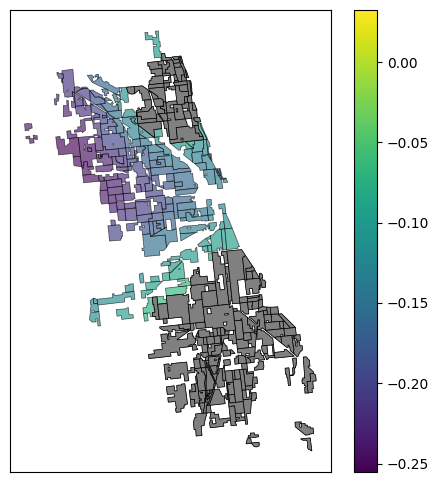

In [57]:
# Hypothesis Tests for Significance of parameter estimates (see Oshan et al., 2019)
map_1_gdf['Redlined_result'] = gwr_model.params[:,1]

# Filter tc gets t values with a correction for multiple dependent hypothesis tests -> distinguishes significant results
filter_tc = gwr_model.filter_tvals() 
map_1_gdf['Redlined_result_tc'] = filter_tc[:,1]

fig, ax = plt.subplots(1, 1, figsize = (6,6))

# map_1_gdf.plot('Redlined_result',
#                **{'edgecolor': 'black',
#                'alpha': .65,
#                'linewidth': .5},
#             ax = ax[0],
#             legend=True)
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
# ax[0].set_title("All Parameter Estimates", fontsize = 28)

map_1_gdf.plot('Redlined_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax,
            legend=True)

map_1_gdf[filter_tc[:,1] == 0].plot(color = 'grey',
                                    ax = ax,
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#ax[1].set_title("Significant Parameter Estimates", fontsize = 28)


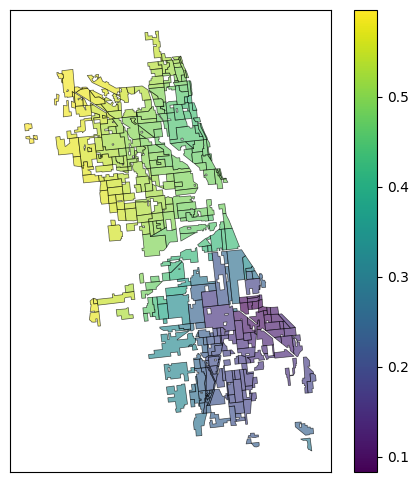

In [63]:
# r-squared

fig, ax = plt.subplots(1, 1, figsize = (6,6))
map_1_gdf.plot('R2',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax,
            legend=True)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [71]:
print(map_1_gdf["R2"].max())

0.5962100570754649


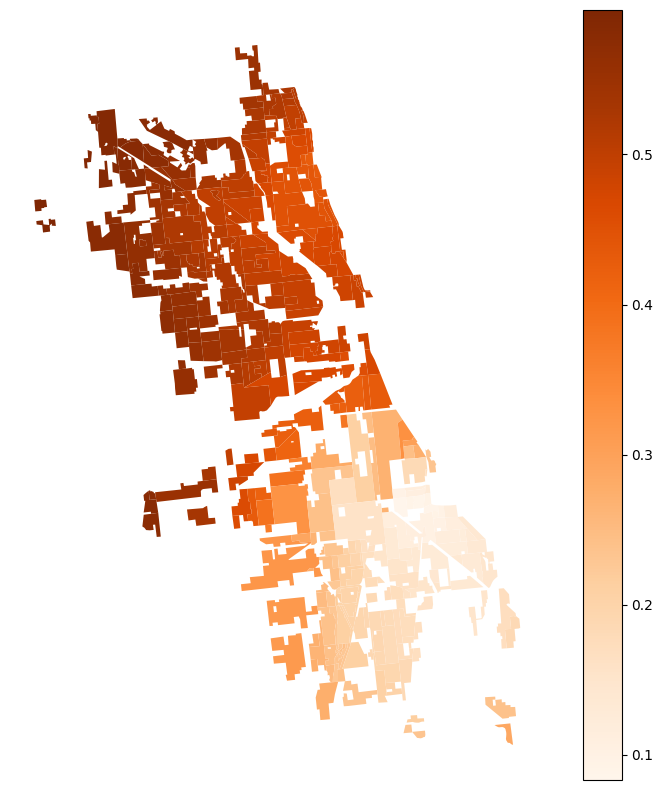

In [84]:
#plot change in r squared across study area
map_1_gdf["R2"] = gwr_model.localR2
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
map_1_gdf.plot("R2",legend=True, cmap = "Oranges", ax=ax)
plt.axis("off")
plt.show()

In [73]:
# deviance residuals
map_1_gdf["GWR_resid"] = gwr_model.resid_response
map_1_gdf["GWR_resid_scale"] = gwr_model.sigma2
map_1_gdf["GWR_dev_resid"] = map_1_gdf["GWR_resid"]/np.sqrt(map_1_gdf["GWR_resid_scale"])
map_1_gdf.columns


Index(['area_id', 'category', 'bb_adoption_prop', 'fiber_prop', 'black_prop',
       'gen_disp', 'pop_density', 'Redlined', 'distance_km', 'geometry',
       'WLS_residuals', 'R2', 'Redlined_result', 'Redlined_result_tc',
       'black_pop_result', 'black_pop_result_tc', 'bb_adopt_result',
       'bb_adopt_result_tc', 'gent_result', 'gent_result_tc', 'pop_den_result',
       'pop_den_result_tc', 'GWR_resid', 'GWR_resid_scale', 'GWR_dev_resid'],
      dtype='object')

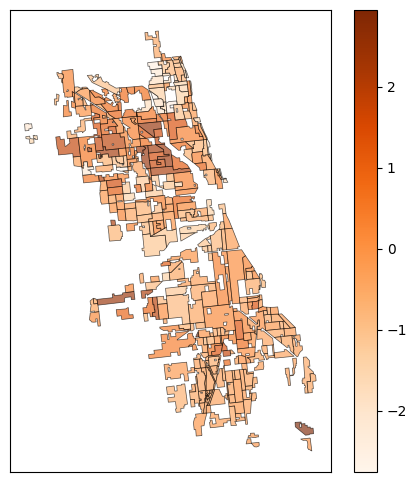

In [76]:

fig, ax = plt.subplots(1, 1, figsize = (6,6))
map_1_gdf.plot('GWR_dev_resid',
               cmap="Oranges",
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax,
            legend=True)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

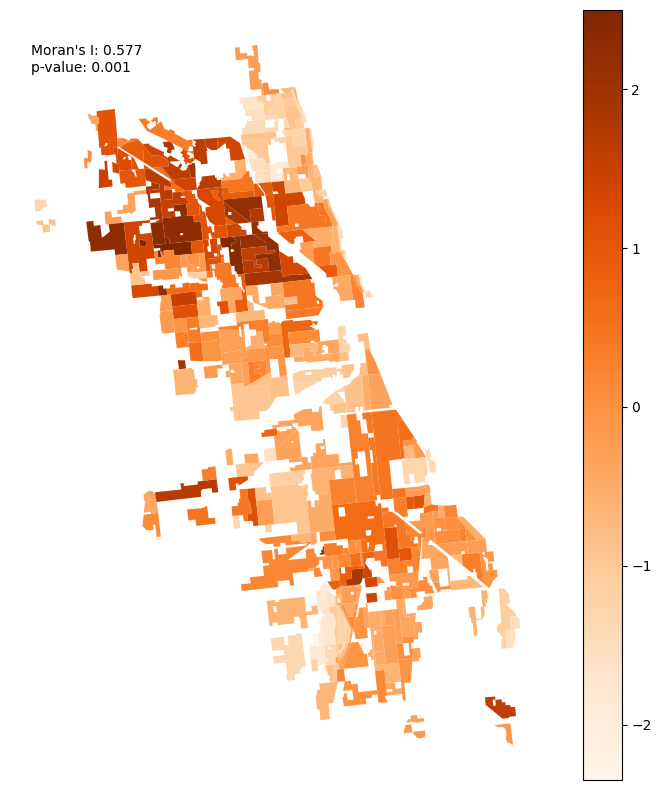

In [77]:
map_1_gdf.plot(column="WLS_residuals", legend=True, figsize=(10, 10), cmap='Oranges')
#plt.title('Residuals by Location')
plt.axis("off")
resid_moran = esda.Moran(map_1_gdf["WLS_residuals"], w_adapt)
plt.text(0.04, 0.92, f"Moran's I: {resid_moran.I:.3f}\np-value: {resid_moran.p_sim:.3f}", transform=plt.gca().transAxes)
plt.show()

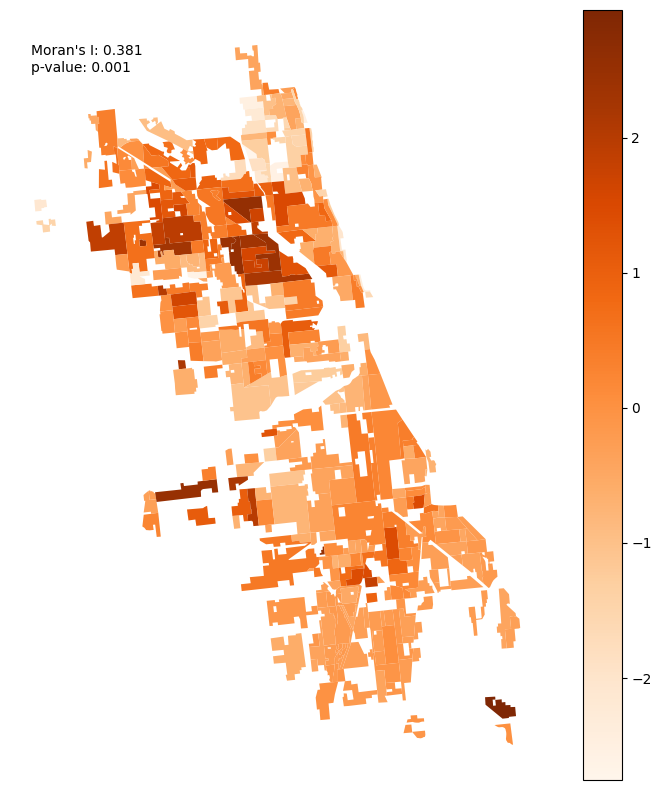

In [78]:
map_1_gdf.plot(column="GWR_dev_resid", legend=True, figsize=(10, 10), cmap='Oranges')
#plt.title('Residuals by Location')
plt.axis("off")
resid_moran = esda.Moran(map_1_gdf["GWR_dev_resid"], w_adapt)
plt.text(0.04, 0.92, f"Moran's I: {resid_moran.I:.3f}\np-value: {resid_moran.p_sim:.3f}", transform=plt.gca().transAxes)
plt.show()

#### Check Results for Current Black Population Demographics

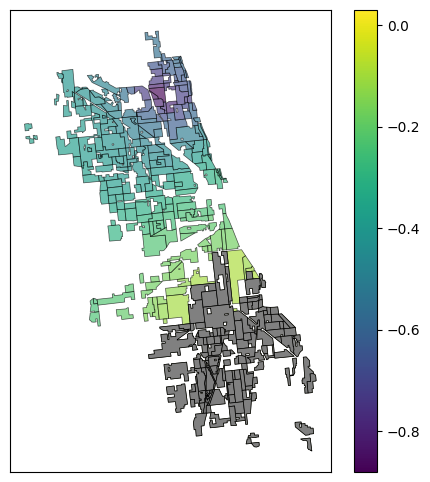

In [56]:
# Hypothesis Tests for Significance of parameter estimates (see Oshan et al., 2019)
map_1_gdf['black_pop_result'] = gwr_model.params[:,3]

# Filter tc gets t values with a correction for multiple dependent hypothesis tests -> distinguishes significant results
filter_tc = gwr_model.filter_tvals() 
map_1_gdf['black_pop_result_tc'] = filter_tc[:,3]

fig, ax = plt.subplots(1, 1, figsize = (6,6))

# map_1_gdf.plot('black_pop_result',
#                **{'edgecolor': 'black',
#                'alpha': .65,
#                'linewidth': .5},
#             ax = ax[0],
#             legend=True)
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
# ax[0].set_title("All Parameter Estimates")

map_1_gdf.plot('black_pop_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax,
            legend=True)

map_1_gdf[filter_tc[:,3] == 0].plot(color = 'grey',
                                    ax = ax,
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax[1].set_title("Significant Parameter Estimates")


#### Broadband adoption

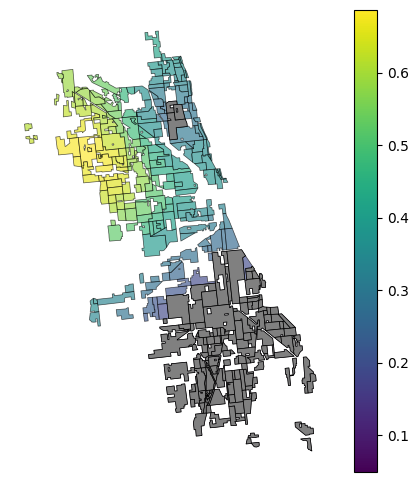

In [79]:
# broadband adoption

map_1_gdf['bb_adopt_result'] = gwr_model.params[:,2]

# Filter tc gets t values with a correction for multiple dependent hypothesis tests -> distinguishes significant results
filter_tc = gwr_model.filter_tvals() 
map_1_gdf['bb_adopt_result_tc'] = filter_tc[:,2]

fig, ax = plt.subplots(1, 1, figsize = (6,6))

# map_1_gdf.plot('bb_adopt_result',
#                **{'edgecolor': 'black',
#                'alpha': .65,
#                'linewidth': .5},
#             ax = ax[0], 
#             legend=True)
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
# ax[0].set_title("All Parameter Estimates")

map_1_gdf.plot('bb_adopt_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax,
            legend=True)

map_1_gdf[filter_tc[:,2] == 0].plot(color = 'grey',
                                    ax = ax,
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_axis_off()
#ax[1].set_title("Significant Parameter Estimates")


#### Gentrification

Text(0.5, 1.0, 'Significant Parameter Estimates')

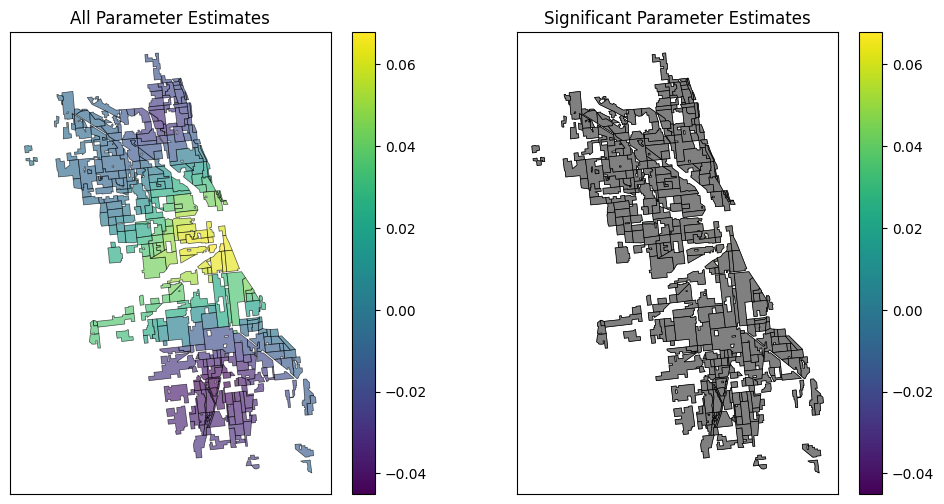

In [38]:
map_1_gdf['gent_result'] = gwr_model.params[:,4]

# Filter tc gets t values with a correction for multiple dependent hypothesis tests -> distinguishes significant results
filter_tc = gwr_model.filter_tvals() 
map_1_gdf['gent_result_tc'] = filter_tc[:,4]

fig, ax = plt.subplots(1, 2, figsize = (12,6))

map_1_gdf.plot('gent_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[0], 
            legend=True)
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)
ax[0].set_title("All Parameter Estimates")

map_1_gdf.plot('gent_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[1],
            legend=True) 

map_1_gdf[filter_tc[:,4] == 0].plot(color = 'grey',
                                    ax = ax[1],
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Significant Parameter Estimates")

#### Population Density

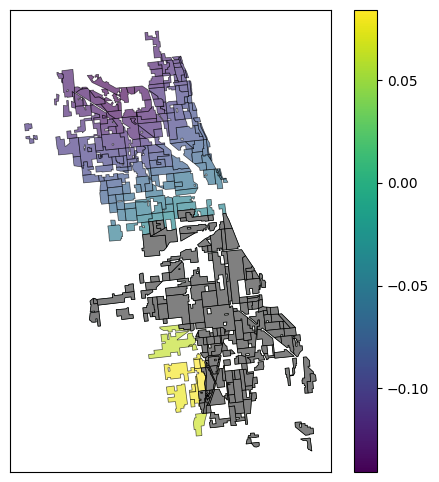

In [49]:
map_1_gdf['pop_den_result'] = gwr_model.params[:,5]

# Filter tc gets t values with a correction for multiple dependent hypothesis tests -> distinguishes significant results
filter_tc = gwr_model.filter_tvals() 
map_1_gdf['pop_den_result_tc'] = filter_tc[:,5]

fig, ax = plt.subplots(1, 1, figsize = (6,6))

# map_1_gdf.plot('pop_den_result',
#                **{'edgecolor': 'black',
#                'alpha': .65,
#                'linewidth': .5},
#             ax = ax[0], 
#             legend=True)
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)
# ax[0].set_title("All Parameter Estimates")

map_1_gdf.plot('pop_den_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax,
            legend=True) 

map_1_gdf[filter_tc[:,5] == 0].plot(color = 'grey',
                                    ax = ax,
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
#ax.set_title("Significant Parameter Estimates")

#### Thesis Visualization


Text(0.5, 1.0, 'Population Density')

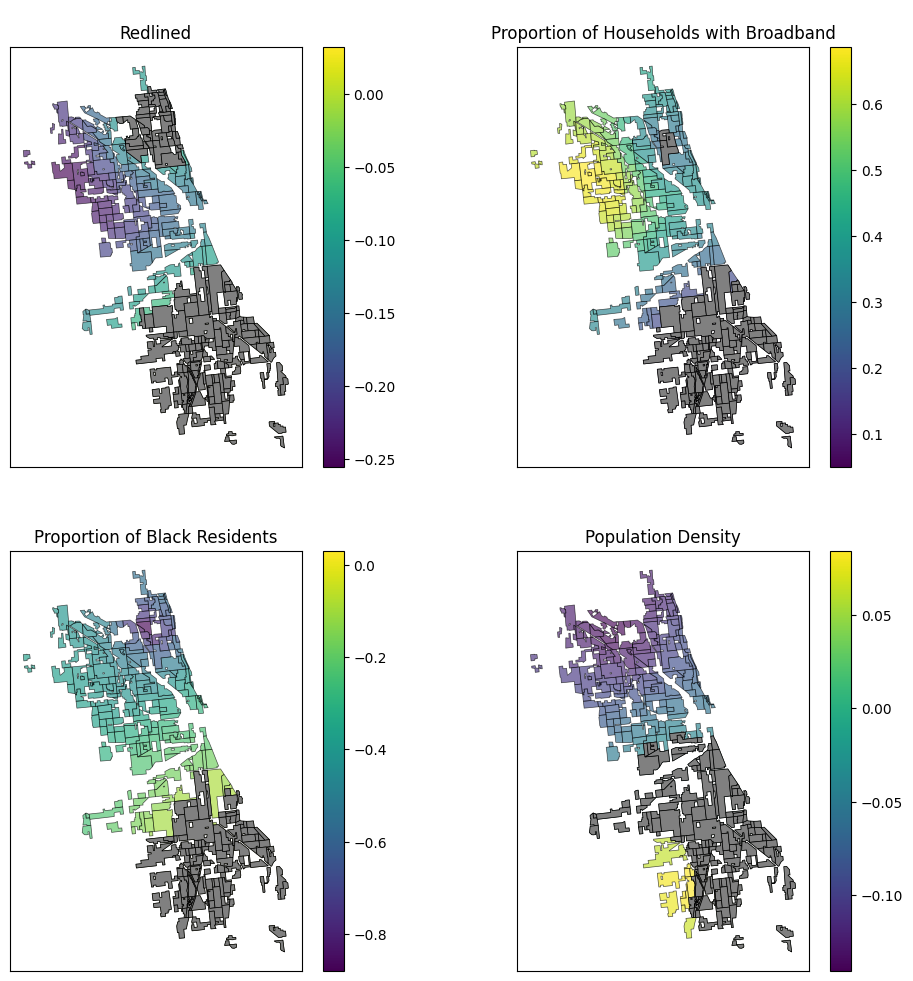

In [47]:
### Plots to use as figures

fig, ax = plt.subplots(2, 2, figsize = (12,12))

map_1_gdf.plot('Redlined_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[0,0],
            legend=True)

map_1_gdf[filter_tc[:,1] == 0].plot(color = 'grey',
                                    ax = ax[0,0],
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax[0,0].get_xaxis().set_visible(False)
ax[0,0].get_yaxis().set_visible(False)
ax[0,0].set_title("Redlined")

map_1_gdf.plot('bb_adopt_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[0,1],
            legend=True)

map_1_gdf[filter_tc[:,2] == 0].plot(color = 'grey',
                                    ax = ax[0,1],
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax[0,1].get_xaxis().set_visible(False)
ax[0,1].get_yaxis().set_visible(False)
ax[0,1].set_title("Proportion of Households with Broadband")

map_1_gdf.plot('black_pop_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[1,0],
            legend=True)

map_1_gdf[filter_tc[:,3] == 0].plot(color = 'grey',
                                    ax = ax[1,0],
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax[1,0].get_xaxis().set_visible(False)
ax[1,0].get_yaxis().set_visible(False)
ax[1,0].set_title("Proportion of Black Residents")


map_1_gdf.plot('pop_den_result',
               **{'edgecolor': 'black',
               'alpha': .65,
               'linewidth': .5},
            ax = ax[1,1],
            legend=True)

map_1_gdf[filter_tc[:,5] == 0].plot(color = 'grey',
                                    ax = ax[1,1],
                                    **{'edgecolor': 'black',
                                       'linewidth': .5})
ax[1,1].get_xaxis().set_visible(False)
ax[1,1].get_yaxis().set_visible(False)
ax[1,1].set_title("Population Density")
